# DDPO

This notebook implements the most DDPO algorithm from the paper.

In [ ]:
from __future__ import annotations
import math, random, torch, matplotlib.pyplot as plt, numpy as np, matplotlib as mpl, shutil, os, gzip, pickle, re, copy
from pathlib import Path
from operator import itemgetter
from itertools import zip_longest
from functools import partial
import fastcore.all as fc
from glob import glob

from torch import tensor, nn, optim
import torch.nn.functional as F
from datasets import load_dataset
from tqdm.auto import tqdm
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler
from diffusers import UNet2DModel
from torch.utils.data import DataLoader, default_collate
from torcheval.metrics import MulticlassAccuracy
from torch.nn import init

from miniai.learner import *
from miniai.datasets import *
from miniai.conv import *
from miniai.activations import *
from miniai.core import *
from miniai.initialisation import *
from miniai.accel import *
from miniai.ddpm import *
from miniai.resnet import *
from miniai.aug import *
from miniai.fid import *
from miniai.diffusion import *

from einops import rearrange
from fastprogress import progress_bar
from PIL import Image
from torchvision.io import read_image,ImageReadMode

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'

### Dataset

The DDPO training schedule involves taking 256 samples at each iteration, using prompts randomly sampled from a list of animals and activities. So, I'm going to build a dictionary that contains the possible prompt combinations that can be used as a lookup table.

In [ ]:
def get_prompt(animal, activity): 
    prefix = "an" if animal[0] in ('a','e','i','o','u') else "a"
    return f"{prefix} {animal} {activity}"

In [ ]:
path = '/home/projects/reinforcement_finetuning'
animals = open(f'{path}/animals.txt', mode='r').readlines()
activities = open(f'{path}/activities.txt', mode='r').readlines()

animals = [i.replace('\n', '') for i in animals]
activities = [i.replace('\n', '') for i in activities]

In [ ]:
get_prompt(animals[0], activities[0])

'a cat washing the dishes'

In [ ]:
str2id = {}
count = 0
for i in animals:
    for j in activities:
        str2id[get_prompt(i, j)] = count
        count += 1
        
id2str = {v:k for k,v in zip(str2id.keys(),str2id.values())}

In [ ]:
str2id['a cat washing the dishes'], id2str[0]

(0, 'a cat washing the dishes')

In [ ]:
# class PromptDS:
#     def __init__(self, animals:list, activities:list, length:int): fc.store_attr()
#     def __len__(self): return self.length
#     def __getitem__(self, i): 
#         idx_1 = torch.randint(0, len(self.animals), (1,))
#         idx_2 = torch.randint(0, len(self.activities), (1,))
#         return str2id[get_prompt(self.animals[idx_1], self.activities[idx_2])]

In [ ]:
class PromptDS:
    def __init__(self, animals:list, activities:list, length:int): 
        self.animals = [animals[torch.randint(len(animals), (1,))] for i in range(length)]
        self.activities = [activities[torch.randint(len(activities), (1,))] for i in range(length)]
        self.seeds = [int(random.random()*1000000) for _ in range(length)]
    def __len__(self): return len(self.animals)
    def __getitem__(self, i): 
        return (str2id[get_prompt(self.animals[i], self.activities[i])], self.seeds[i]), 0

In [ ]:
tds = PromptDS(animals, activities, 9000)
len(tds)

9000

In [ ]:
vds = PromptDS(animals, activities, 1000)
len(vds)

1000

In [ ]:
tds[0]

((121, 849232), 0)

In [ ]:
class DataLoaders:
    def __init__(self, train, valid, bs, **kwargs): 
        fc.store_attr()
        self._make_dataloaders()
    def _make_dataloaders(self):
        self.train = DataLoader(self.train, batch_size=self.bs, num_workers=4, collate_fn=default_collate, shuffle=True)
        self.valid = DataLoader(self.valid, batch_size=self.bs, num_workers=4, collate_fn=default_collate)

In [ ]:
bs = 1
dls = DataLoaders(tds, vds, bs)
(prompts, seeds), a = next(iter(dls.train))
prompts, seeds

(tensor([83]), tensor([450891]))

In [ ]:
id2str[prompts.item()], seeds[0].item()

('a mouse playing chess', 450891)

The dataloader is going to serve the model with a batch of randomly sampled prompts, together with a random seed. 

### Embeddings

In [ ]:
from transformers import AutoTokenizer, CLIPTextModel

tokeniser = AutoTokenizer.from_pretrained('runwayml/stable-diffusion-v1-5', subfolder='tokenizer')
text_encoder = CLIPTextModel.from_pretrained('runwayml/stable-diffusion-v1-5', subfolder='text_encoder')

In [ ]:
def get_embeddings(prompt, unconditional=False, device='cpu'):
    text_input = tokeniser(prompt, padding="max_length", max_length=tokeniser.model_max_length, truncation=True, return_tensors="pt")
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokeniser([""], padding="max_length", max_length=max_length, return_tensors="pt")
    with torch.no_grad():
        embeds = text_encoder(text_input.input_ids)[0]
        if unconditional:
            uncond_embeddings = text_encoder(uncond_input.input_ids)[0]
            embeds = torch.cat([uncond_embeddings, embeds])
    return embeds.to(device)

In [ ]:
id2embed = {k:get_embeddings(v).cpu() for k,v in id2str.items()}

In [ ]:
max(id2embed.keys())

134

In [ ]:
id2embed[135] = get_embeddings("")

In [ ]:
del(tokeniser)
del(text_encoder)
clean_gpu()

### Prompt alignment objective

#### BERTScore

The BERTScore measures the semantic alignment between two sentences. I'm going to use the original BERTScore library as there are some complexities to implementing BERT that are out of scope for this project.

In [ ]:
from bert_score import BERTScorer

bert = BERTScorer(model_type='roberta-large', lang='en', rescale_with_baseline=True)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
text = ['Here is my shitty text for testing Bert']
compare_1 = ["Butt butt boop boop flip flobble"]
compare_2 = ["Here is my delightfully well crafted text for testing Bert"]

In [ ]:
p, r, f1 = bert.score(text, compare_1)
p, r, f1

(tensor([0.07]), tensor([-0.25]), tensor([-0.09]))

In [ ]:
p, r, f1 = bert.score(text, compare_2)
p, r, f1

(tensor([0.83]), tensor([0.63]), tensor([0.73]))

In [ ]:
p, r, f1 = bert.score(text, text)
p, r, f1

(tensor([1.]), tensor([1.]), tensor([1.]))

#### LLaVA

The weights for the LLaVA model can be retrieved by applying a delta function on top of the pretrained LLaMA model. You should definitely not find a torrent file for LLaMA here, because that would be bad. I am going to use both models and see which works best, and follow the instructions in the [LLaVA GitHub repo](https://github.com/haotian-liu/LLaVA#llava-weights). 

First step is to convert from the params.json format to the HF format.

##### Hide for now

In [ ]:
! python /home/transformers/src/transformers/models/llama/convert_llama_weights_to_hf.py \
    --input_dir /home/models/foundation/LLaMA/ --model_size 7B --output_dir /home/models/foundation/LLaMA/7b/llama_7b_hf

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Fetching all parameters from the checkpoint at /home/models/foundation/LLaMA/7B.
Loading the checkpoint in a Llama model.
Loading checkpoint shards: 100%|████████████████| 33/33 [00:10<00:00,  3.19it/s]
Saving in the Transformers format.
Saving a LlamaTokenizerFast to /home/models/foundation/LLaMA/7b/llama_7b_hf.


Apply the delta function.

In [ ]:
! python /home/models/foundation/LLaVA/llava/model/apply_delta.py \
    --base /home/models/foundation/LLaMA/7B/llama_7b_hf \
    --target /home/models/foundation/LLaVA/7B/llava_7b_hf \
    --delta liuhaotian/LLaVA-7b-delta-v0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Loading base model
Loading checkpoint shards: 100%|██████████████████| 2/2 [00:07<00:00,  3.88s/it]
Loading delta
You are using a model of type llama to instantiate a model of type llava. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.7.layer_norm2.bias', 'text_model.encoder.layers.2.self_attn.v_proj.weight', 'text_model.encoder.layers.7.self_attn.out_proj.bias', 'text_model.encoder.layers.3.mlp.fc1.weight', 'text_model.encoder.layers.10.self_attn.v_proj.weight', 'text_model.encoder.layers.8.se

Now we have the LLaVA model weights, we can use them for inference. I'm going to adapt the inference script from the [LLaVA GitHub repo](https://github.com/haotian-liu/LLaVA#llava-weights) — we just need to prompt the model with an image and some text, and it will spit out a response. We will then measure the BERTScore between the response and the original prompt.

##### Continue

In [ ]:
import argparse
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import os
from llava.conversation import conv_templates, SeparatorStyle
from llava.utils import disable_torch_init
from transformers import CLIPVisionModel, CLIPImageProcessor, StoppingCriteria
from llava.model import *
from llava.model.utils import KeywordsStoppingCriteria

from PIL import Image

import os
import requests
from PIL import Image
from io import BytesIO

In [ ]:
DEFAULT_IMAGE_TOKEN = "<image>"
DEFAULT_IMAGE_PATCH_TOKEN = "<im_patch>"
DEFAULT_IM_START_TOKEN = "<im_start>"
DEFAULT_IM_END_TOKEN = "<im_end>"

In [ ]:
def setup_tokenizer(tokenizer):
    """Adds new tokens to the tokenizer."""
    tokenizer.add_tokens([DEFAULT_IMAGE_PATCH_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN], special_tokens=True)
    return tokenizer

In [ ]:
path = '/home/models/foundation/LLaVA/7B/llava-7B-v0/'
llava_tokenizer = setup_tokenizer(AutoTokenizer.from_pretrained(path))
llava_model = LlavaLlamaForCausalLM.from_pretrained(path, low_cpu_mem_usage=True, torch_dtype=torch.float16, use_cache=True).cuda()
image_processor = CLIPImageProcessor.from_pretrained(llava_model.config.mm_vision_tower, torch_dtype=torch.float16)

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.6.self_attn.out_proj.bias', 'text_model.encoder.layers.8.layer_norm1.weight', 'text_model.encoder.layers.8.self_attn.v_proj.weight', 'text_model.encoder.layers.3.self_attn.q_proj.weight', 'text_model.encoder.layers.3.layer_norm1.bias', 'text_model.encoder.layers.10.self_attn.q_proj.weight', 'text_model.encoder.layers.11.layer_norm2.bias', 'text_model.encoder.layers.0.mlp.fc2.bias', 'text_model.encoder.layers.4.self_attn.q_proj.weight', 'text_model.encoder.layers.11.self_attn.k_proj.weight', 'text_model.encoder.layers.8.mlp.fc1.bias', 'text_model.encoder.layers.7.self_attn.k_proj.weight', 'text_model.encoder.layers.11.self_attn.k_proj.bias', 'text_model.encoder.layers.9.self_attn.q_proj.bias', 'text_model.encoder.layers.0.layer_norm2.bias', 'text_model.encoder.layers.3.layer_norm2.bias', 'text_model.encoder.layers.1.layer_norm1.weight', 'text

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
def setup_vision_tower(model, tokenizer, mm_use_im_start_end=True):
    vision_tower = model.get_model().vision_tower[0]
    if vision_tower.device.type == 'meta':
        vision_tower = CLIPVisionModel.from_pretrained(vision_tower.config._name_or_path, torch_dtype=torch.float16, low_cpu_mem_usage=True).cuda()
        model.get_model().vision_tower[0] = vision_tower
    else:
        vision_tower.to(device='cuda', dtype=torch.float16)
    vision_config = vision_tower.config
    vision_config.im_patch_token = tokenizer.convert_tokens_to_ids([DEFAULT_IMAGE_PATCH_TOKEN])[0]
    vision_config.use_im_start_end = mm_use_im_start_end
    if mm_use_im_start_end:
        vision_config.im_start_token, vision_config.im_end_token = tokenizer.convert_tokens_to_ids([DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN])
    return model, vision_config, vision_tower

In [ ]:
def get_llava_prompt(query, image_token_len, mm_use_im_start_end=True):
    if mm_use_im_start_end:
        query = query + '\n' + DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_PATCH_TOKEN * image_token_len + DEFAULT_IM_END_TOKEN
    else:
        query = query + '\n' + DEFAULT_IMAGE_PATCH_TOKEN * image_token_len
    
    conv_mode = "multimodal"

    conv = conv_templates[conv_mode].copy()
    conv.append_message(conv.roles[0], query)
    conv.append_message(conv.roles[1], None)
    return conv, conv.get_prompt()

In [ ]:
def llava_query(query, image, model, clip, tokenizer, device='cuda'):
    # Assumes that the tokenizer has been setup with setup_tokenizer
    mm_use_im_start_end = getattr(model.config, "mm_use_im_start_end", False)
    model, vision_config, vision_tower = setup_vision_tower(model, tokenizer, mm_use_im_start_end)
    
    image_token_len = (vision_config.image_size // vision_config.patch_size) ** 2
    conv, prompt = get_llava_prompt(query, image_token_len)
    input_ids = torch.as_tensor(tokenizer([prompt]).input_ids).to(device)
    image = image_processor.preprocess(image, return_tensors='pt')['pixel_values'][0].to(device)

    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    keywords = [stop_str]
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)

    with torch.inference_mode():
        output_ids = model.generate(
            input_ids,
            images=image.unsqueeze(0).half(),
            do_sample=True,
            temperature=0.2,
            max_new_tokens=64,
            stopping_criteria=[stopping_criteria])

    input_token_len = input_ids.shape[1]
    n_diff_input_output = (input_ids != output_ids[:, :input_token_len]).sum().item()
    if n_diff_input_output > 0:
        print(f'[Warning] {n_diff_input_output} output_ids are not the same as the input_ids')
    outputs = tokenizer.batch_decode(output_ids[:, input_token_len:], skip_special_tokens=True)[0]
    outputs = outputs.strip()
    if outputs.endswith(stop_str):
        outputs = outputs[:-len(stop_str)]
    return outputs.strip()

In [ ]:
query = 'what is happening in this image?'
image = read_image('/home/artbear.jpeg', ImageReadMode.RGB)
llava_query(query, image, llava_model, image_processor, llava_tokenizer)

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.6.self_attn.out_proj.bias', 'text_model.encoder.layers.8.layer_norm1.weight', 'text_model.encoder.layers.8.self_attn.v_proj.weight', 'text_model.encoder.layers.3.self_attn.q_proj.weight', 'text_model.encoder.layers.3.layer_norm1.bias', 'text_model.encoder.layers.10.self_attn.q_proj.weight', 'text_model.encoder.layers.11.layer_norm2.bias', 'text_model.encoder.layers.0.mlp.fc2.bias', 'text_model.encoder.layers.4.self_attn.q_proj.weight', 'text_model.encoder.layers.11.self_attn.k_proj.weight', 'text_model.encoder.layers.8.mlp.fc1.bias', 'text_model.encoder.layers.7.self_attn.k_proj.weight', 'text_model.encoder.layers.11.self_attn.k_proj.bias', 'text_model.encoder.layers.9.self_attn.q_proj.bias', 'text_model.encoder.layers.0.layer_norm2.bias', 'text_model.encoder.layers.3.layer_norm2.bias', 'text_model.encoder.layers.1.layer_norm1.weight', 'text

'In the image, there is a detailed and colorful picture of a panda bear, which appears to be a part of a more complex and brightly colored picture. The panda bear seems to be looking up, possibly towards the camera.'

Finally, we can wrap this functionality into a top-level function.

In [ ]:
def prompt_alignment_score(prompt, image, query="", llava_model=None, clip_model=None, llava_tokenizer=None, bert=None, return_all=False):
    image = (image.clip(-1,1) + 1) / 2
    llava_out = llava_query(query, image, llava_model, clip_model, llava_tokenizer)
    p, r, f1 = bert.score([prompt], [llava_out])
    return (p,r,f1) if return_all else r

##### Test

Okay, this should now work. I'm going to test it by sampling an image and comparing the prompts with a BERTScore.

In [ ]:
def sample(p, model, seed=None, height=512, width=512, steps=50, guidance_scale=5, device='cuda'):
    if seed is None: seed = int(torch.rand((1,)) * 1000000)
    embeddings = torch.cat([id2embed[135], id2embed[p.item()]]).to(device)
    scheduler.set_timesteps(steps)
    shape = (1, model.in_channels, height // 8, width // 8)
    latents = torch.randn(shape, generator=torch.manual_seed(seed)).to(device)
    latents = latents * scheduler.init_noise_sigma
    
    for i, t in enumerate(progress_bar(scheduler.timesteps, leave=False)):
        latent_model_input = torch.cat([latents] * 2).to(device)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)
        with torch.no_grad():
            noise_pred = model(latent_model_input, t, encoder_hidden_states=embeddings).sample

        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        latents = scheduler.step(noise_pred, t, latents).prev_sample
        
    latents = 1 / 0.18215 * latents
    with torch.no_grad(): image = vae.decode(latents).sample
    return image

In [ ]:
from diffusers import UNet2DConditionModel, AutoencoderKL, LMSDiscreteScheduler, DDIMScheduler
from transformers import AutoTokenizer, CLIPTextModel
from diffusers import UNet2DConditionModel

vae = AutoencoderKL.from_pretrained('runwayml/stable-diffusion-v1-5', subfolder='vae').to('cuda')
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule='scaled_linear')
sd_model = UNet2DConditionModel.from_pretrained('runwayml/stable-diffusion-v1-5', subfolder='unet').to('cuda')

/tmp/ipykernel_400/4161473821.py:5: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  shape = (1, model.in_channels, height // 8, width // 8)


<Axes: title={'center': 'a cat washing the dishes'}>

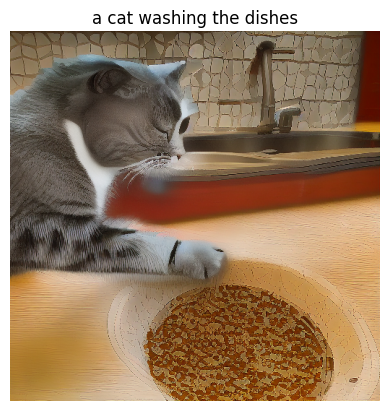

In [ ]:
image = sample(tensor(0), sd_model, steps=50)
show_image((image.cpu()[0].clip(-1,1) + 1)/2, title=id2str[0])

In [ ]:
query = "what is happening in this image?"
llava_query(query, (image.clip(-1,1)+1)/2, llava_model, image_processor, llava_tokenizer)

'In the image, a gray and white cat is sitting on a counter next to a sink. The cat is looking down at a small bowl or plate that is placed on the counter.'

In [ ]:
query = 'what is happening in this image?'
p, r, f1 = prompt_alignment_score(id2str[0], image, query, llava_model, image_processor, llava_tokenizer, bert, return_all=True)
p, r, f1

(tensor([0.25]), tensor([0.14]), tensor([0.20]))

/tmp/ipykernel_140/4161473821.py:5: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  shape = (1, model.in_channels, height // 8, width // 8)


<Axes: title={'center': 'a cat washing the dishes'}>

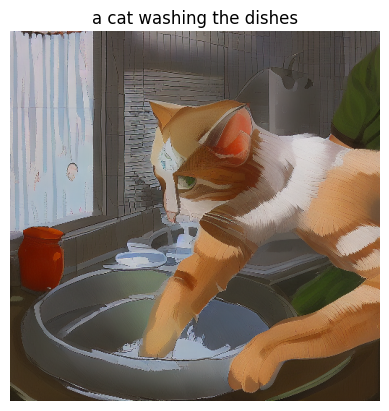

In [ ]:
image = sample(tensor(0), sd_model, seed=5, steps=50)
show_image((image.cpu()[0].clip(-1,1) + 1)/2, title=id2str[0])

In [ ]:
query = 'what is happening in this image?'
p, r, f1 = prompt_alignment_score(id2str[0], image, query, llava_model, image_processor, llava_tokenizer, bert)
p, r, f1

(tensor([0.28]), tensor([0.10]), tensor([0.19]))

In [ ]:
llava_query(query, (image.clip(-1,1) + 1) / 2, llava_model, image_processor, llava_tokenizer)

'In the image, a person is washing a brown and white cat in a sink in a kitchen. The cat is being bathed with a cloth, and the water is being changed every few minutes to keep the cat clean.'

The paper specifies the recall metric as the reward function, so the reward score here would be `0.11`. I'm a little skeptical here as (having tried a few) LLaVA 7B vanilla is not always good at describing the image. Above is a good example — I would personally rate this image quite highly relative to the prompt 'a cat washing the dishes', but LLaVA does not pick up the context. Or maybe that's a person in the top right?? It also comes up with weird details, like in this example 'the water is being changed every few minutes to keep the cat clean'.

I suspect the 13B model would perform better.

### Training

Below is an implementation of the $DDPO_{IS}$ algorithm. We are going to sample a 'batch' of 256 images from sequential iterations of the model. In each batch of 256, we are going to perform 4 gradient updates. 

I've modified the sample function below to enable sampling multiple images in one go — in my case, I suspect that my maximum batch size will be 1 image on a single GPU and I will use gradient accumulation to reach the minibatch size of 256/4 = 64. On a more powerful GPU setup, the idea would be to do all 64 images of a minibatch in one go, and perform the gradient update. I'm going use a dictionary to store information about the sample, including all of the intermediate latents so that they can be used for training.

In [ ]:
def sample(samples, model, scheduler, height=512, width=512, steps=50, guidance_scale=5, device='cuda'):
    model.eval()
    for i, sample in progress_bar(samples.items(), leave=False, comment='generating samples...'):
        seed = sample['seed'] if sample['seed'] is not None else int(torch.rand((1,)) * 1000000)
        embeddings = torch.cat([id2embed[135], id2embed[sample['prompt'].item()]]).to(device)
        scheduler.set_timesteps(steps)
        shape = (1, model.in_channels, height // 8, width // 8)
        latents = torch.randn(shape, generator=torch.manual_seed(seed)).to(device)
        latents = latents * scheduler.init_noise_sigma
        
        for i, t in enumerate(progress_bar(scheduler.timesteps, leave=False)):
            sample['latents'].append(latents)
            latent_model_input = torch.cat([latents] * 2).to(device)
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)
            with torch.no_grad():
                noise_pred = model(latent_model_input, t, encoder_hidden_states=embeddings).sample

            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
            latents, log_prob = scheduler.step(noise_pred, t, latents)
            sample['next_latents'].append(latents)
            sample['log_prob'].append(log_prob)

        latents = 1 / 0.18215 * latents
        with torch.no_grad(): image = vae.decode(latents).sample
        sample['final_image'] = image
        
    return samples

Having sampled from the model, we'll calculate the reward function using the generated images. However, rewards aren't used as-calculated, and rather normalised with a running mean and standard deviation. This is done on a per-prompt basis, with a running mean and standard deviation for each of the 135 possible prompts from the combination of animals and activities. The class below handles stat collection and calculation.

In [ ]:
class RunningStats:
    def __init__(self, min_count=2, eps=1e-6):
        fc.store_attr()
        self.stats = {}
    def get_norm_rewards(self, prompts, rewards):
        norm_rewards = []
        self._update(prompts.cpu(), rewards.cpu())
        for i, p in enumerate(prompts):
            p = p.item()
            if len(self.stats[p]) >= self.min_count:
                mean = torch.cat(self.stats[p]).mean()
                std = torch.cat(self.stats[p]).std() + self.eps
                norm_rewards.append((rewards[i] - mean) / std)
            else:
                norm_rewards.append(rewards[i])
        return torch.stack(norm_rewards)
    def _update(self, prompts, rewards):
        for p in torch.unique(prompts):
            p = p.item()
            if not p in self.stats: self.stats[p] = []
            p_rewards = rewards[prompts == p]
            for r in p_rewards: self.stats[p].append(r.unsqueeze(0))

To calculate the $DDPO_{IS}$ loss function, we need to do some further work.

$$\hat{g} = \mathbb{E} \left[ \frac{p_{\theta}(x_{t-1} | c,t,x_{t})}{p_{\theta_{old}}(x_{t-1} | c,t,x_{t})} \nabla_{\theta}\log{p_{\theta}}(x_{t-1} | c,t,x_{t}) \space r(x_{0},c) \right]$$

The algorithm involves using importance sampling to enable multiple gradient updates in a single sampling iteration. To do so, we need to calculate a ratio as below. This ratio is composed of probabilities calculated from the current model parameters (updated after each minibatch of 64 from total batch size of 256 samples) and the parameters used to collect 256 samples for the current batch.

$$\frac{p_{\theta}(x_{t-1} | c,t,x_{t})}{p_{\theta_{old}}(x_{t-1} | c,t,x_{t})}$$

To get this ratio, we can calculate the *log* probability at each denoising step easily, since each transition distribution is a normal distribution.

$$p(x_{t-1} | c,t,x_{t}) = \frac{1}{\sigma \sqrt{2\pi}} exp \left(-\frac{(x-\mu)^2}{2\sigma^2} \right) $$

$$\log{p(x_{t-1} | c,t,x_{t})} = -\frac{(x - \mu)^2}{2\sigma^2} - \log{\sigma} - \log{\sqrt{2\pi}}$$

And then use log rules to find the ratio.

$$\frac{p_{\theta}(x_{t-1} | c,t,x_{t})}{p_{\theta_{old}}(x_{t-1} | c,t,x_{t})} = exp \left(\log{p_{\theta}(x_{t-1} | c,t,x_{t})} - \log{p_{\theta_{old}}(x_{t-1} | c,t,x_{t})} \right)$$

One way to do this is to augment the scheduler functionality to calculate and return the log probability at each denoising step, as below. The scheduler takes an additional optional argument when training, `prev_sample`, which will reuse the same value of $x_{t-1}$ calculated during the original sampling procedure while calculating a new mean. This provides us with two values for $p_{\theta}(x_{t-1} | c,t,x_{t})$ - one with the current parameters and one with the original sampling parameters. 

In [ ]:
from diffusers import DDIMScheduler
from diffusers.utils import randn_tensor

In [ ]:
class DDIMScheduler(DDIMScheduler):
    def step(
        self,
        model_output: torch.FloatTensor,
        timestep: int,
        sample: torch.FloatTensor,
        eta: float = 1.0,
        use_clipped_model_output: bool = False,
        generator=None,
        variance_noise: Optional[torch.FloatTensor] = None,
        return_dict: bool = True,
        prev_sample: Optional[torch.FloatTensor] = None
    ) -> Union[DDIMSchedulerOutput, Tuple]:
        """
        Predict the sample at the previous timestep by reversing the SDE. Core function to propagate the diffusion
        process from the learned model outputs (most often the predicted noise).
        Args:
            model_output (`torch.FloatTensor`): direct output from learned diffusion model.
            timestep (`int`): current discrete timestep in the diffusion chain.
            sample (`torch.FloatTensor`):
                current instance of sample being created by diffusion process.
            eta (`float`): weight of noise for added noise in diffusion step.
            use_clipped_model_output (`bool`): if `True`, compute "corrected" `model_output` from the clipped
                predicted original sample. Necessary because predicted original sample is clipped to [-1, 1] when
                `self.config.clip_sample` is `True`. If no clipping has happened, "corrected" `model_output` would
                coincide with the one provided as input and `use_clipped_model_output` will have not effect.
            generator: random number generator.
            variance_noise (`torch.FloatTensor`): instead of generating noise for the variance using `generator`, we
                can directly provide the noise for the variance itself. This is useful for methods such as
                CycleDiffusion. (https://arxiv.org/abs/2210.05559)
            return_dict (`bool`): option for returning tuple rather than DDIMSchedulerOutput class
        Returns:
            [`~schedulers.scheduling_utils.DDIMSchedulerOutput`] or `tuple`:
            [`~schedulers.scheduling_utils.DDIMSchedulerOutput`] if `return_dict` is True, otherwise a `tuple`. When
            returning a tuple, the first element is the sample tensor.
        """
        if self.num_inference_steps is None:
            raise ValueError(
                "Number of inference steps is 'None', you need to run 'set_timesteps' after creating the scheduler"
            )

        # See formulas (12) and (16) of DDIM paper https://arxiv.org/pdf/2010.02502.pdf
        # Ideally, read DDIM paper in-detail understanding

        # Notation (<variable name> -> <name in paper>
        # - pred_noise_t -> e_theta(x_t, t)
        # - pred_original_sample -> f_theta(x_t, t) or x_0
        # - std_dev_t -> sigma_t
        # - eta -> η
        # - pred_sample_direction -> "direction pointing to x_t"
        # - pred_prev_sample -> "x_t-1"

        # 1. get previous step value (=t-1)
        prev_timestep = timestep - self.config.num_train_timesteps // self.num_inference_steps

        # 2. compute alphas, betas
        alpha_prod_t = self.alphas_cumprod[timestep.cpu()]
        alpha_prod_t_prev = self.alphas_cumprod[prev_timestep.cpu()] if prev_timestep >= 0 else self.final_alpha_cumprod

        beta_prod_t = 1 - alpha_prod_t

        # 3. compute predicted original sample from predicted noise also called
        # "predicted x_0" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
        if self.config.prediction_type == "epsilon":
            pred_original_sample = (sample - beta_prod_t ** (0.5) * model_output) / alpha_prod_t ** (0.5)
            pred_epsilon = model_output
        elif self.config.prediction_type == "sample":
            pred_original_sample = model_output
            pred_epsilon = (sample - alpha_prod_t ** (0.5) * pred_original_sample) / beta_prod_t ** (0.5)
        elif self.config.prediction_type == "v_prediction":
            pred_original_sample = (alpha_prod_t**0.5) * sample - (beta_prod_t**0.5) * model_output
            pred_epsilon = (alpha_prod_t**0.5) * model_output + (beta_prod_t**0.5) * sample
        else:
            raise ValueError(
                f"prediction_type given as {self.config.prediction_type} must be one of `epsilon`, `sample`, or"
                " `v_prediction`"
            )

        # 4. Clip or threshold "predicted x_0"
        if self.config.thresholding:
            pred_original_sample = self._threshold_sample(pred_original_sample)
        elif self.config.clip_sample:
            pred_original_sample = pred_original_sample.clamp(
                -self.config.clip_sample_range, self.config.clip_sample_range
            )

        # 5. compute variance: "sigma_t(η)" -> see formula (16)
        # σ_t = sqrt((1 − α_t−1)/(1 − α_t)) * sqrt(1 − α_t/α_t−1)
        variance = self._get_variance(timestep, prev_timestep)
        std_dev_t = eta * variance ** (0.5)

        if use_clipped_model_output:
            # the pred_epsilon is always re-derived from the clipped x_0 in Glide
            pred_epsilon = (sample - alpha_prod_t ** (0.5) * pred_original_sample) / beta_prod_t ** (0.5)

        # 6. compute "direction pointing to x_t" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
        pred_sample_direction = (1 - alpha_prod_t_prev - std_dev_t**2) ** (0.5) * pred_epsilon

        # 7. compute x_t without "random noise" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
        prev_sample_mean = alpha_prod_t_prev ** (0.5) * pred_original_sample + pred_sample_direction

        if eta > 0 and prev_sample is None:
            if variance_noise is not None and generator is not None:
                raise ValueError(
                    "Cannot pass both generator and variance_noise. Please make sure that either `generator` or"
                    " `variance_noise` stays `None`."
                )

            if variance_noise is None:
                variance_noise = randn_tensor(
                    model_output.shape, generator=generator, device=model_output.device, dtype=model_output.dtype
                )
            variance = std_dev_t * variance_noise

            prev_sample = prev_sample_mean + variance

        if not return_dict:
            return (prev_sample,)
        
        log_prob = self._get_logprob(prev_sample, prev_sample_mean, std_dev_t)

        return prev_sample, log_prob
    
    def _get_logprob(self, x, mean, std):
        # x_clone = x.clone()
        # mean_clone = mean.clone()
        log_prob = -((x-mean)**2 / 2 * (std**2 + 1e-5)) - (std + 1e-5).log() - tensor(torch.pi * 2).log()
        return log_prob.mean([1,2,3])

In [ ]:
from diffusers import UNet2DConditionModel, AutoencoderKL

vae = AutoencoderKL.from_pretrained('runwayml/stable-diffusion-v1-5', subfolder='vae').to('cuda')
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule='scaled_linear')
sd_model = UNet2DConditionModel.from_pretrained('runwayml/stable-diffusion-v1-5', subfolder='unet').to('cuda')

Since we are training Stable Diffusion, we can take advantage of LoRA to reduce the training footprint within the attention modules. Hugging Face has a good implementation of LoRA which is built to work with their models. Since I am using a pretrained Hugging Face SD model, I'll use the Hugging Face setup for LoRA. Bear in mind that a large proportion of the training time in this instance is taken by sampling in each iteration and measuring the reward via LLaVA/BERT, while each 'iteration' contains 50 training steps. So, I wouldn't expect LoRA to have much of an impact on the training time. It will, atleast, make the trained model file much smaller, which is useful.

In [ ]:
from diffusers.loaders import AttnProcsLayers
from diffusers.models.attention_processor import LoRAAttnProcessor

In [ ]:
class LoRACB(Callback):
    order = DeviceCB.order + 1
    def before_fit(self):
        lora_attn_procs = {}
        for name in self.learn.model.attn_processors.keys():
            cross_attention_dim = None if name.endswith("attn1.processor") else self.learn.model.config.cross_attention_dim
            if name.startswith("mid_block"):
                hidden_size = self.learn.model.config.block_out_channels[-1]
            elif name.startswith("up_blocks"):
                block_id = int(name[len("up_blocks.")])
                hidden_size = list(reversed(self.learn.model.config.block_out_channels))[block_id]
            elif name.startswith("down_blocks"):
                block_id = int(name[len("down_blocks.")])
                hidden_size = self.learn.model.config.block_out_channels[block_id]
                
            lora_attn_procs[name] = LoRAAttnProcessor(hidden_size=hidden_size, cross_attention_dim=cross_attention_dim)
        
        self.learn.model.set_attn_processor(lora_attn_procs)
        self.learn.lora_layers = AttnProcsLayers(self.learn.model.attn_processors).to(self.learn.model.device)
        self.learn.opt = self.learn.opt_func(self.learn.lora_layers.parameters(), self.learn.lr)
        # for pg in self.learn.opt.param_groups: pg['params'] = self.learn.lora_layers.parameters()

I am also going to write a checkpointing callback, which will save the weights at specified intervals during the training process as well as the final lora weights.

In [ ]:
from safetensors import safe_open
from safetensors.torch import save_file

In [ ]:
class CheckpointCB(Callback):
    def __init__(self, model_name, file_path, lora=False, safetensors=True, checkpoint_intervals=None): 
        super().__init__()
        fc.store_attr()
        if not file_path.endswith("/"): self.file_path = f"{self.file_path}/"
        if not Path(file_path).exists(): os.makedirs(file_path)
        self.checkpoint_counter = 0
    def after_batch(self):
        if self.checkpoint_intervals is not None and self.learn.batch_idx % self.checkpoint_intervals == 0:
            weights = self.learn.model.state_dict()
            opt = self.learn.opt.state_dict()
            folder = os.makedirs(f'{self.file_path}{self.model_name}_checkpoint_{self.checkpoint_counter}/', exist_ok=True)
            if self.safetensors:
                save_file(weights, f"{folder}model_weights")
                save_file(weights, f"{folder}optimiser")
            else:    
                torch.save(weights, f"{folder}model_weights.bin")
                torch.save(opt, f"{folder}optimiser.bin")
            self.checkpoint_counter += 1
    def after_fit(self):
        save_params = self.learn.lora_layers.state_dict() if self.lora else self.learn.model.parameters()
        if self.safetensors: save_file(save_params, f"{self.file_path}{self.model_name}_lora")
        else: torch.save(save_params, f"{self.file_path}{self.model_name}_lora.bin")

With all these pieces in place, we are ready to write the training script!

In [ ]:
import random
from torch.nn.utils import clip_grad_norm_

In [ ]:
class DDPOCB(MixedPrecisionCB):
    order = LoRACB.order + 1
    def __init__(
        self, 
        reward_func, 
        scheduler,
        batch_size=256, 
        denoising_steps=50, 
        train_steps=50, 
        clip_max=10.0, 
        clip_range=1e-4, 
        guidance_scale=5., 
        mixed_precision=torch.float16,
        n_inp=1
    ): 
        super().__init__(mixed_precision, n_inp)
        fc.store_attr()
        self.running_stats = RunningStats()
        self.gradient_accumulation_steps = self.batch_size // 4
    def before_fit(self):
        self.scaler = torch.cuda.amp.GradScaler()
        self.prev_model = copy.deepcopy(self.learn.model).requires_grad_(False).to('cuda')
        self.learn.rewards = []
        self.learn.norm_rewards = []
        self.learn.losses = []
    def predict(self):
        self.batch_losses = []
        prompts, seeds = self.learn.xb
        device = prompts.device
        
        # sample
        sample_dict = {
            s_id: {
                "prompt": prompts[s_id],
                "final_image": 0,
                "reward_norm": 0,
                "latents": [],
                "next_latents": [],
                "log_prob": [],
                "seed": seeds[s_id]
            } 
            for s_id in range(len(prompts))
        }
        self.samples = sample(sample_dict, self.prev_model, self.scheduler)
        rewards = torch.cat([self.reward_func(id2str[s['prompt'].item()], s['final_image']) 
                        for s in progress_bar(self.samples.values(), leave=False, comment='calculating rewards...')])
        norm_rewards = self.running_stats.get_norm_rewards(prompts, rewards).to(device)
        
        # logging
        for i in range(len(norm_rewards)): 
            self.learn.rewards.append(rewards[i].cpu().item())
            self.learn.norm_rewards.append(norm_rewards[i].cpu().item())
        
        # training loop
        t_idx = [tensor(random.sample(range(self.denoising_steps), self.train_steps)) for i in range(len(self.samples))]
        self.learn.model.train()
        for step in progress_bar(range(self.train_steps), leave=False, comment='training...'):
            self.scheduler.set_timesteps(self.train_steps)
            batch_t = torch.stack([self.scheduler.timesteps[ts_list[step]] for ts_list in t_idx]*2)
            batch_latents = torch.cat([self.samples[i]['latents'][ts_list[step]] for i, ts_list in enumerate(t_idx)]*2)
            batch_embeds = torch.cat([
                torch.cat([id2embed[135] for i in range(len(self.samples))]), # unconditional embeddings
                torch.cat([id2embed[s['prompt'].item()] for s in self.samples.values()]) # conditional embeddings
            ]).to(device)

            uncond, cond = self.learn.model(batch_latents, batch_t.to(device), batch_embeds).sample.chunk(2)
            noise_pred = uncond + self.guidance_scale * (cond - uncond)
            batch_next_latents = torch.cat([self.samples[i]['next_latents'][ts_list[step]] for i, ts_list in enumerate(t_idx)])
            batch_logprob = torch.stack([self.samples[i]['log_prob'][ts_list[step]] for i, ts_list in enumerate(t_idx)])
            
            log_probs = []
            for i in range(len(batch_next_latents)):
                n, t, l, nl = noise_pred[i][None,:], batch_t[i], batch_latents[i][None,:], batch_next_latents[i][None,:]
                _, log_prob = self.scheduler.step(n, t, l, prev_sample=nl)
                if log_prob == torch.nan: print(step)
                log_probs.append(log_prob)

            # ddpo_is objective
            ip_ratio = (torch.stack(log_probs) - batch_logprob).exp()
            norm_rewards = norm_rewards.clip(-self.clip_max, self.clip_max)
            loss_unclipped = -ip_ratio * norm_rewards
            loss_clipped = -ip_ratio.clip(1. - self.clip_range, 1. + self.clip_range) * norm_rewards
            self.learn.loss = torch.stack([max(z) for z in zip(loss_unclipped, loss_clipped)]).mean()
            self.batch_losses.append(self.learn.loss.detach().cpu().item())
            self.scaler.scale(self.learn.loss).backward()
        
        self.learn.losses.append(tensor(self.batch_losses).mean().cpu().item())
    
    def get_loss(self): return
    def backward(self): return
    def step(self):
        if (self.learn.batch_idx + 1) % self.gradient_accumulation_steps == 0: 
            self.scaler.unscale_(self.learn.opt)
            clip_grad_norm_(self.learn.lora_layers.parameters(), 1.0)
            self.scaler.step(self.learn.opt)
            self.scaler.update()
    def zero_grad(self):
        if (self.learn.batch_idx + 1) % self.gradient_accumulation_steps == 0:
            self.learn.opt.zero_grad()
        if (self.learn.batch_idx + 1) % self.batch_size == 0:
            self._save_model()
    def _save_model(self):
        self.prev_model.load_state_dict(self.learn.model.state_dict())
        self.prev_model.requires_grad_(False)

Finally, we want to be able to see what's happening throughout the training process. The callback below enables flexible addition of graphs updated on a per-sample basis. I am going to display the reward and normalised reward for each sample, along with the mean loss over training steps for that sample.

In [ ]:
class DDPOProgressCB(ProgressCB):
    def __init__(self, plot=False): 
        self.plot = plot
        if plot: self.losses, self.counter = [], 0
    def after_batch(self):
        mbar = self.mbar
        if not hasattr(mbar, 'graph_fig'):
            mbar.graph_fig, mbar.graph_axs = plt.subplots(1, 3, figsize=(18, 3.5))
            mbar.graph_out = display(mbar.graph_fig, display_id=True)
            
        titles = ['Reward', 'Normalised Reward', 'Loss']
        items = [self.learn.rewards, self.learn.norm_rewards, self.learn.losses]
        for i, (title, item) in enumerate(zip(titles, items)):
            mbar.graph_axs[i].clear()
            mbar.graph_axs[i].plot(item, '.', alpha=0.3)
            mbar.graph_axs[i].set_ylim(tensor(item).min(), tensor(item).max())
            mbar.graph_axs[i].set_title(title)
        
        # Update graph
        mbar.graph_out.update(mbar.graph_fig)

So, to recap, we have the following components:

- "Prompt alignment" reward function, which feeds the sampled image into the LLaVA vision-language model together with a prompt, "what is happening in this image?". LLaVA returns a string answer, which is fed into the BERT scoring model together with the prompt that produced the sample. This returns a metric that measures the semantic similarity between the two sentences. More similar sentences lead to a higher reward, as it is more likely that the sampled image matches the prompt.
- A `RunningStats` object, which calculates normalised rewards on a per-prompt basis, across the 134 possible prompts derived from the combinations between all the animals and all the activities in the original lists. Normalised rewards are used to calculate the loss for each iteration.
- A `LoRA` callback function, which adapts the model such that only a small projection of the original model weights are trained. While we shouldn't expect this to affect the speed of training too much in this instance, it will make the final model file smaller.
- An augmented DDIM scheduler, which samples images as normal, but also calculates the log probability at each denoising step in order to enable importance sampling normalisation of the loss.

The training script does the following:

- Samples images from the model using a saved earlier iteration of the weights.
- Saves the intermediate latents and log probabilities at each denoising step.
- Calculates rewards for the final sampled images, then normalises them.
- Trains the model on each of the denoising steps in a random order.
- Measures the DDPO loss function via importance sampling of the reward.
- Applies a gradient update every 64 images.
- Saves a new iteration of the model every 256 images to be used for sampling.

In [ ]:
lr, epochs = 1e-5, 5
llava_prompt = "what is happening in this image?"
reward = partial(prompt_alignment_score, query=llava_prompt, llava_model=llava_model, clip_model=image_processor, llava_tokenizer=llava_tokenizer, bert=bert, return_all=False)
ddpo = DDPOCB(reward, scheduler)
path = '/home/projects/reinforcement_finetuning/models/'
checkpoint = CheckpointCB("ddpo_1", path, checkpoint_intervals=5000)
cbs = [DeviceCB(), MetricsCB(), LoRACB(), checkpoint, ddpo, DDPOProgressCB()]
learn = Learner(dls, sd_model, cbs=cbs, opt_func=partial(optim.AdamW, weight_decay=1e-4, eps=1e-5))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/tmp/ipykernel_2498/1666208011.py:7: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  shape = (1, model.in_channels, height // 8, width // 8)


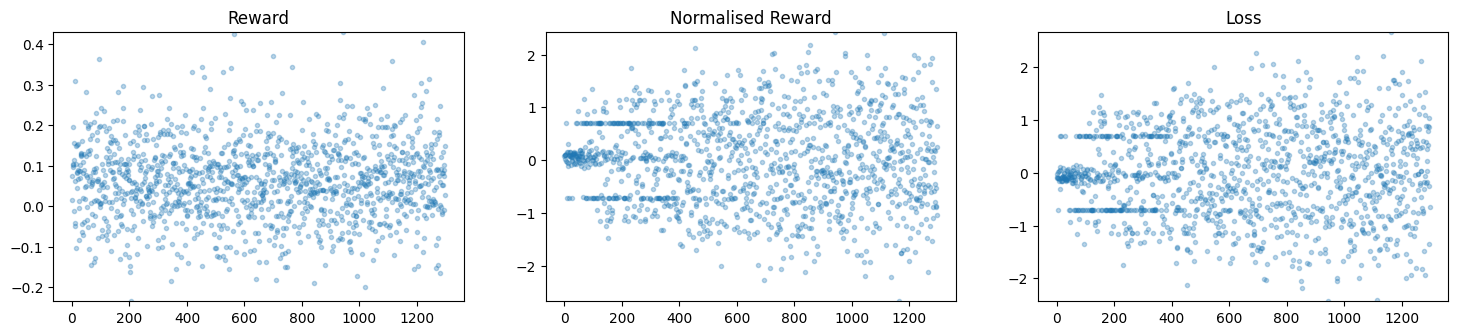

/tmp/ipykernel_2498/1383120575.py:16: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  mbar.graph_axs[i].set_ylim(tensor(item).min(), tensor(item).max())


/tmp/ipykernel_2498/1666208011.py:7: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  shape = (1, model.in_channels, height // 8, width // 8)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
learn.fit(lr, epochs)

Expectations:
- The rewards can only start to change every 256 iterations — they are being calculated using the previous version of the model. So, the expected shape should be like stairs.
- The loss can only change every 64 iterations